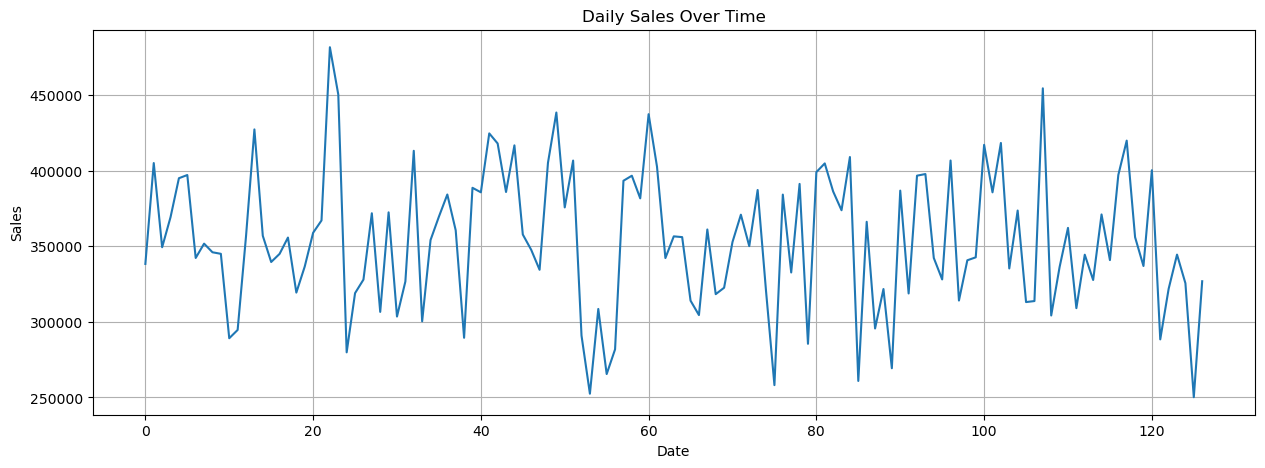

Index(['Order Date', 'Total Sales Amount'], dtype='object')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel('Daily_Sales_Aggregated.xlsx')
df['Order Date'] = pd.to_datetime(df['Order Date'])
plt.figure(figsize=(15, 5))
plt.plot(df['Total Sales Amount'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()
print(df.columns)

In [ ]:
import matplotlib.pyplot as plt


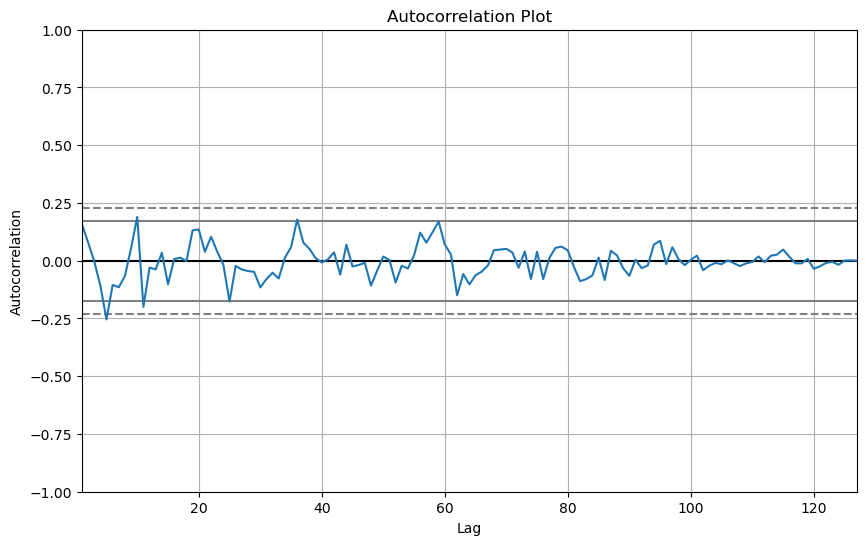

In [4]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(10, 6))
autocorrelation_plot(df['Total Sales Amount'])
plt.title('Autocorrelation Plot')
plt.show()


In [5]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Total Sales Amount'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("Data is not stationary – we need differencing.")
else:
    print("Data is stationary – we can proceed.")


ADF Statistic: -4.4275748912433786
p-value: 0.0002651969071638562
Data is stationary – we can proceed.


In [7]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# 1. DATA PREPARATION ======================================================
prophet_df = df[['Order Date', 'Total Sales Amount']].rename(
    columns={'Order Date': 'ds', 'Total Sales Amount': 'y'}
)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df = prophet_df.dropna()

In [9]:
#2.MODEL TRAINING ========================================================

model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

# Optional: add monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit the model
model.fit(prophet_df)

01:29:39 - cmdstanpy - INFO - Chain [1] start processing
01:29:40 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
#3. FORECAST GENERATION ===================================================

# Forecast for next 30 days
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

# 4. EVALUATION ============================================================

# Merge actual and forecasted data on 'ds'
merged = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate metrics
mae = mean_absolute_error(merged['y'], merged['yhat'])
mape = mean_absolute_percentage_error(merged['y'], merged['yhat'])

print("\nModel Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")



Model Performance Metrics:
MAE: 33929.28
MAPE: 9.90%


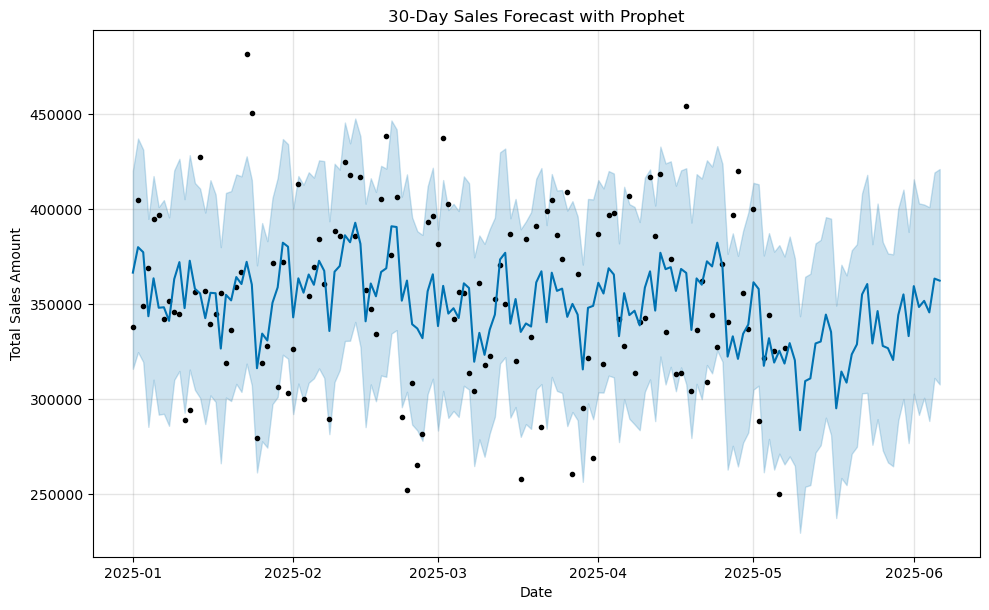

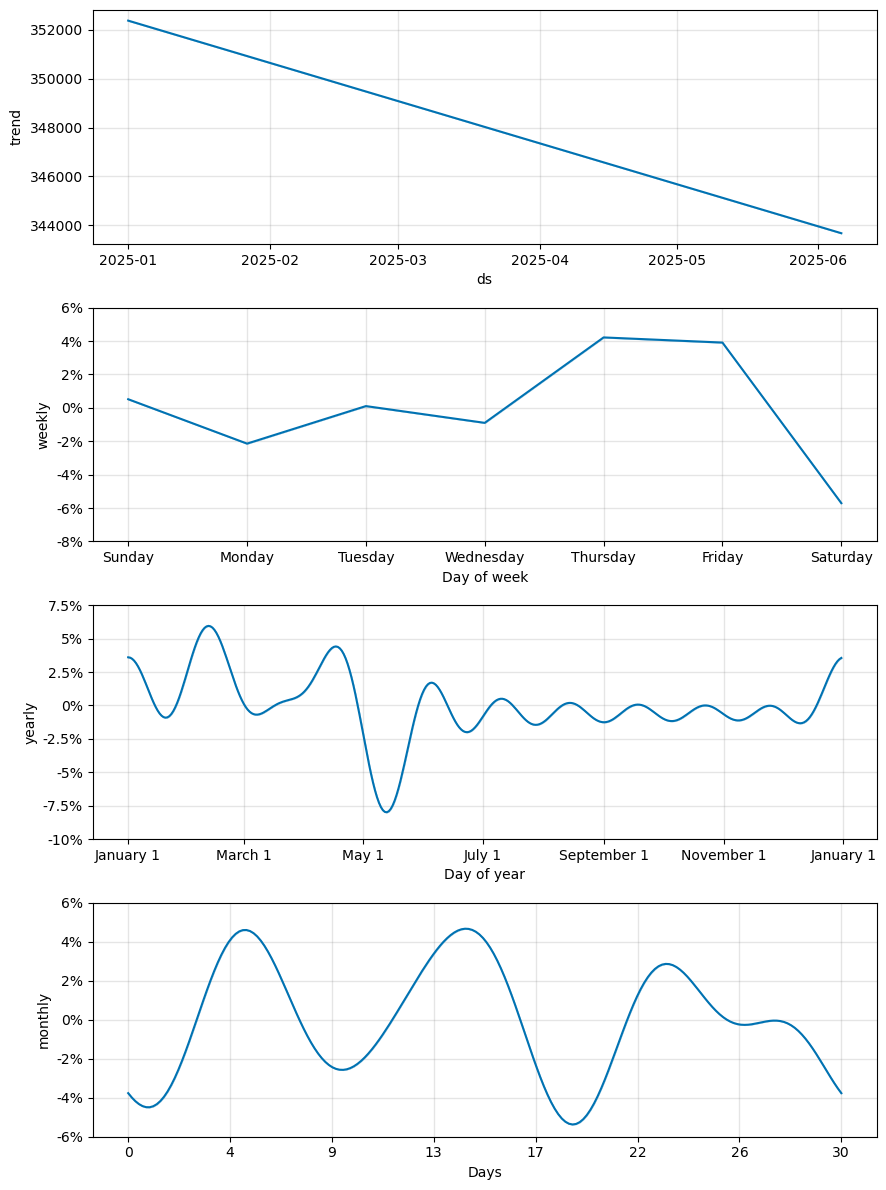


30-Day Forecast Results:
    Order Date  Forecasted Sales  Lower Bound  Upper Bound  \
127 2025-05-08         329627.07    270014.50    385685.73   
128 2025-05-09         320598.46    265050.93    374271.40   
129 2025-05-10         283814.86    229846.37    343769.26   
130 2025-05-11         309645.31    254046.87    364530.70   
131 2025-05-12         311061.05    254943.39    366122.46   
132 2025-05-13         329439.93    272022.33    382091.09   
133 2025-05-14         330460.42    275915.76    383923.39   
134 2025-05-15         344634.77    290403.78    395886.88   
135 2025-05-16         335519.63    281311.04    395090.77   
136 2025-05-17         295321.92    237597.04    349336.28   
137 2025-05-18         314647.35    258651.56    370850.05   
138 2025-05-19         308842.64    254933.43    365265.07   
139 2025-05-20         323688.69    271393.30    378441.01   
140 2025-05-21         328980.60    275093.10    381676.64   
141 2025-05-22         355248.66    303218.1

In [11]:
# Static plot
fig1 = model.plot(forecast)
plt.title('30-Day Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()

# Plot components
fig2 = model.plot_components(forecast)
plt.show()

# Optional: Interactive plot
plot_plotly(model, forecast)

# 6. RESULTS EXPORT =========================================================

# Get last 30 days of forecast
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30).copy()
forecast_results = forecast_results.rename(
    columns={
        'ds': 'Order Date',
        'yhat': 'Forecasted Sales',
        'yhat_lower': 'Lower Bound',
        'yhat_upper': 'Upper Bound'
    }
)

# Add confidence interval width
forecast_results['Confidence Interval'] = forecast_results['Upper Bound'] - forecast_results['Lower Bound']

print("\n30-Day Forecast Results:")
print(forecast_results.round(2))


In [12]:
forecast = model.predict(future)


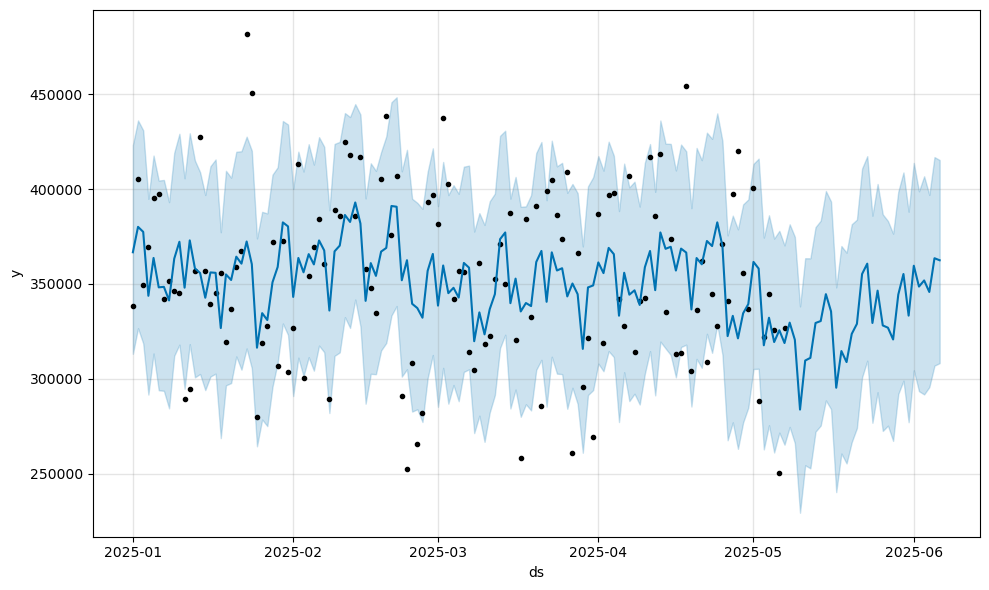

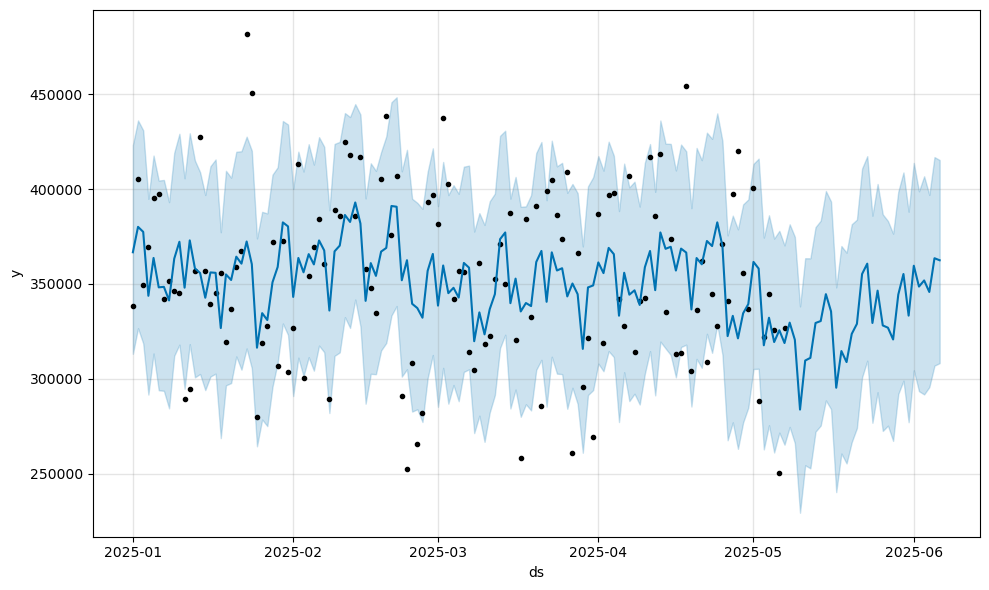

In [13]:
model.plot(forecast)


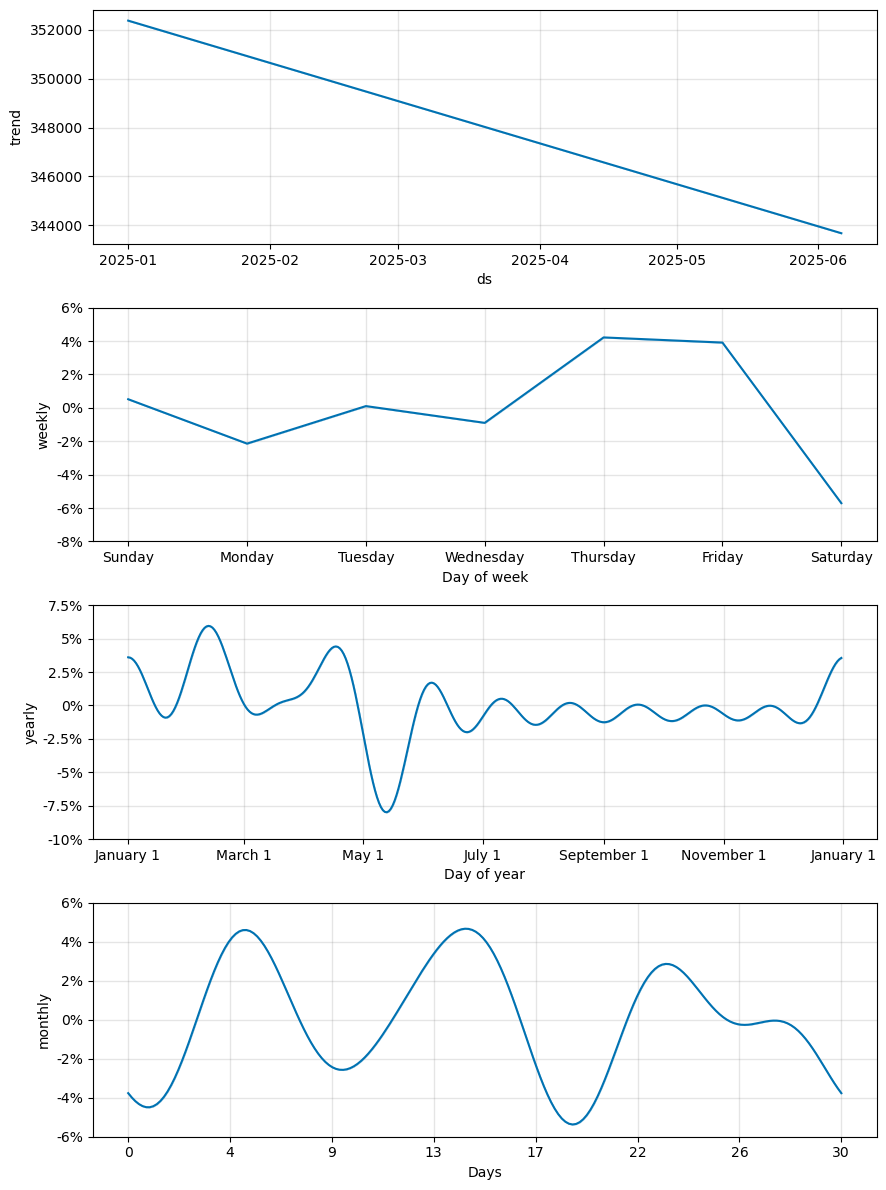

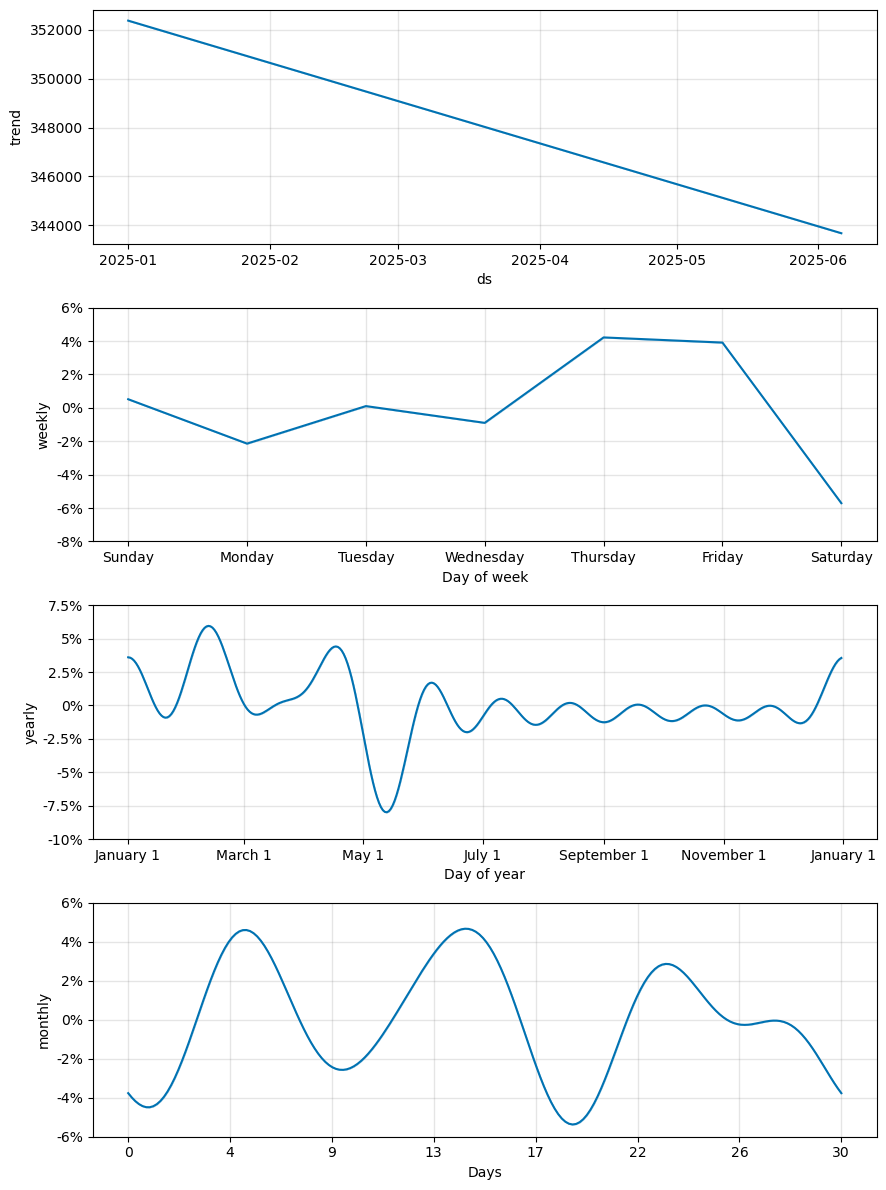

In [14]:
model.plot_components(forecast)


In [15]:
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")


MAE: 33929.28
MAPE: 9.90%


In [16]:

import joblib
joblib.dump(model, 'sales_forecast_model.pkl')


['sales_forecast_model.pkl']